In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import subprocess
import random
import numpy as np
from matplotlib import pyplot as plt
import json

In [3]:
def call_RNAfold(sequence):
    sequence = sequence.replace('T', 'U')
    MyOut = subprocess.Popen(['RNAfold', '-p', '--noPS', '--noDP', '--constraint'],
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE, 
            stderr=subprocess.STDOUT)
    stdout, stderr = MyOut.communicate(input=str.encode(sequence))
    return stdout

def get_energy_RNAfold(stdout_string):
    '''
    '''
    temp = stdout_string.decode('utf-8') 
    mfe_line = temp.split('\n')[-5]
    mfe_val = mfe_line[mfe_line.index(' '):]
    mfe_val = mfe_val.strip().strip('()').strip()
    #
    ensemble_line = temp.split('\n')[-4]
    ensemble_val = ensemble_line[ensemble_line.index(' '):]
    ensemble_val = ensemble_val.strip().strip('[]').strip()
    return float(ensemble_val), float(mfe_val)

# Read in data

In [4]:
# virus_df = pd.read_csv('../Data/MVP_data/host_linked_genomes/562_rep_viruses/7841.clean.tsv',\
#                        sep='\t', index_col=0)
virus_df = pd.read_csv('../Data/benchmark_viruses/T7.clean.tsv',\
                       sep='\t', index_col=0)
print(virus_df.shape)
virus_df.head()

(57, 18)


,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,upstream_sequence,aSD_binding,sec_struct,sec_struct_bound,iCUB,GC_cds,GC_upstream,viral_id
0,NC_001604.1,RefSeq,CDS,925,1278,.,+,0,ID=cds-NP_041954.1;Parent=rna-T7p01;Dbxref=Uni...,ATGGCTATGTCTAACATGACTTACAACAACGTTTTCGACCACGCTT...,TTCACTAATAACTGCACGAGGTAACACAAG,-5.42,-10.13,-3.81,50.525906,0.468927,0.400000,cds-NP_041954.1
1,NC_001604.1,RefSeq,CDS,1278,1433,.,+,0,ID=cds-NP_041955.1;Parent=gene-T7p02;Dbxref=Un...,ATGTCTACTACCAACGTGCAATACGGTCTGACCGCTCAAACTGTAC...,AGTCGAGGAGTACGAGGAGGATGAAGAGTA,-9.31,-19.01,-12.96,43.066882,0.455128,0.500000,cds-NP_041955.1
2,NC_001604.1,RefSeq,CDS,2021,3100,.,+,0,ID=cds-NP_041959.1;Parent=rna-T7p03;Dbxref=GOA...,ATGAACATTACCGACATCATGAACGCTATCGACGCAATCAAAGCAC...,TCTCATAACGAACATAAAGGACACAATGCA,-4.00,-7.46,-3.80,55.711182,0.493519,0.366667,cds-NP_041959.1
3,NC_001604.1,RefSeq,CDS,1496,1639,.,+,0,ID=cds-NP_041956.1;Parent=gene-T7p04;Dbxref=Un...,ATGTATATGCTTACTATCGGTCTACTCACCGCTCTAGGTCTAGCTG...,TATGATTATCACTTTACTTATGAGGGAGTA,-5.82,-19.87,-8.50,39.155014,0.458333,0.300000,cds-NP_041956.1
6,NC_001604.1,RefSeq,CDS,1636,1797,.,+,0,ID=cds-NP_041958.1;Parent=gene-T7p06;Dbxref=Un...,ATGATGAAGCACTACGTTATGCCAATCCACACGTCCAACGGGGCAA...,CATAGGAATCATCAAAGGGGCACTACGCAA,-5.53,-17.68,-7.52,42.406008,0.481481,0.466667,cds-NP_041958.1


# Set up some basic parameters

In [30]:
choices = {'A': ['T', 'G', 'C'], ###A boring mutational matrix
           'T': ['A', 'G', 'C'],
           'G': ['A', 'T', 'C'],
           'C': ['A', 'T', 'G']}

n_reps_per_gene = 200
expected_utr_len = 30

###For aSD calculations
gaps = (4,10)
RBS_len = 6 
with open('../Data/energy_files/energyRef_CCUCCU_ensemble_noneConstraint.json', 'r') as infile:
       energy_dict = json.load(infile)

# Measuring the impact of random point mutations

In [40]:
folding_energies_ddg = []
asd_energies_ddg = []

###Whether to run for all genes or only weak secondary structure genes
temp_df = virus_df[virus_df['sec_struct'] >= virus_df['sec_struct'].median()]
# temp_df = virus_df


for index in temp_df.index:
    us_seq = virus_df.loc[index]['upstream_sequence'] 
    cds_seq = virus_df.loc[index]['coding_sequence']
    if len(cds_seq) < 90:
        continue
    beg_cds_seq = cds_seq[:60]
    
    
    test_string = us_seq.replace('T', 'U')
    ###Ensure that the sequence is the proper expected length
    if len(test_string) != expected_utr_len:
        continue
    ###Ensure that the sequence has no abnormal bases
    if test_string.count('A') + test_string.count('U') +\
                                test_string.count('C') + test_string.count('G') != expected_utr_len:
        continue

    ###Calculate the energy for the indicated gap offsets
    temp_asd_list = []
    for gap in range(gaps[0],gaps[1]+1):
         temp_asd_list.append(energy_dict[test_string[-gap - RBS_len: -gap]])
    best_asd = np.min(temp_asd_list)
    
    if len(us_seq) == 30 and len(beg_cds_seq) == 60:
        seq = us_seq + beg_cds_seq
        rna_out = call_RNAfold(seq)
        e1, e2 = get_energy_RNAfold(rna_out)
        
        temp_folding_dg = []
        temp_asd_dg = []
        for i in range(n_reps_per_gene):
            listy = list(seq)
            position = random.randint(0, 89)
            listy[position] = random.choice(choices[listy[position]])
            new_seq = ''.join(listy)
            rna_out = call_RNAfold(new_seq)
            _e1, _e2 = get_energy_RNAfold(rna_out)
            temp_folding_dg.append(_e1)

            test_string = new_seq[0:30].replace('T', 'U')
            ###Calculate the energy for the indicated gap offsets
            temp_asd_list = []
            for gap in range(gaps[0],gaps[1]+1):
                 temp_asd_list.append(energy_dict[test_string[-gap - RBS_len: -gap]])
            best_asd_mut = np.min(temp_asd_list)
            temp_asd_dg.append(best_asd_mut)
            
            
        temp_folding_ddg = list(e1 - np.array(temp_folding_dg))
        folding_energies_ddg.append(temp_folding_ddg)
        
        temp_asd_ddg = list(best_asd - np.array(temp_asd_dg))
        asd_energies_ddg.append(temp_asd_ddg)

0.15431034482758627 0.08999999999999986


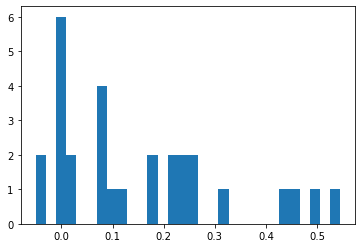

In [46]:
# tempy = [np.mean(i) for i in asd_energies_ddg]
# tempy = [np.median(i) for i in asd_energies_ddg]
# tempy = [inner for outer in asd_energies_ddg for inner in outer]

# tempy = [np.mean(i) for i in folding_energies_ddg]
tempy = [np.median(i) for i in folding_energies_ddg]
# tempy = [inner for outer in folding_energies_ddg for inner in outer]


fig, ax = plt.subplots()
ax.hist(tempy, bins=30);
print(np.mean(tempy), np.median(tempy))